# **Predicting the perception of deprivation from VHR Satelite Images.**

## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [32]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras import backend as K

Check the version of Tensorflow. It should be 2.8.0

In [4]:
print(tf.__version__)

2.8.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [5]:
! nvidia-smi

Thu Feb 24 15:38:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 24%   35C    P0    53W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 17%   

Configure Tensorflow (v2.8) for deterministic behavior (to get reproducible results). See official manual [HERE](https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism). NOTICE: Has never worked properly :/

In [6]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
# Enable determinism was not possible in this context of fine-tuning of model with BatchNorm weights should be kept on inference mode with training=False.
# It rased the error "A deterministic GPU implementation of fused batch-norm backprop, when training is disabled, is not currently available."
# See official Keras documentation on this point: https://keras.io/guides/transfer_learning/

#tf.config.experimental.enable_op_determinism()

Setup Keras to work with Mixed Precision to speed up the learning process and reduce GPU memory required. More information [HERE](https://keras.io/api/mixed_precision/).

In [8]:
# Setup Keras Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


Import custom functions

In [9]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

In [27]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file

Test is GPU(s) is(are) available for processing and measure the speed-up of using it(them). 

In [11]:
%run ../SRC/Check_GPU_available.py

2 Physical GPUs, 2 Logical GPUs
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.0563716919859871
GPU (s):
0.0333163479808718
GPU speedup over CPU: 31x


# 1. Data preparation 

**In this part, we load the data prepared before**

### 1.1 Loading, structuring the data

In [50]:
# Set ID of experiment
experiment_id = 2

In [51]:
# Define working path 
root = "/home/tgrippa/PARTIMAP_processing"
data_path = os.path.join(root, "data")
output_path = os.path.join(root, "output_exp_%s" %experiment_id)
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [52]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path, data_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/tgrippa/PARTIMAP_processing/output_exp_2' has been created
The folder '/home/tgrippa/PARTIMAP_processing/output_exp_2/model' has been created
The folder '/home/tgrippa/PARTIMAP_processing/output_exp_2/results' has been created
The folder '/home/tgrippa/PARTIMAP_processing/data' already exists


In [53]:
with h5py.File(os.path.join(data_path,"RGNIR_224.hdf5"), mode="r") as f:
    x_train = np.asarray(f["x_train"])
    x_test = np.asarray(f["x_test"])
    y_train = np.asarray(f["y_train"])
    y_test = np.asarray(f["y_test"])

## 2. Deep CNN-based Regression Model 

In this part, we build a VGG-like model to predict the deprivation degree.

The CNN model has 4 convolution blocks and 3 fully connected layers. The details were presented below

### 2.1 Models Architecture Definition

#### **DenseNet121**

In [16]:
## DenseNet121 model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [54]:
def DenseNet121_model(inputshape=(224,224,3)):    
    # Create the base pre-trained model without the classification head
    base_model = DenseNet121(input_shape=inputshape, weights='imagenet', include_top=False)  
    inputs = keras.Input(shape=inputshape)
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(254, activation='relu')(x)
    # and a linear activation layer with 1 neuron for the regression
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    return base_model, model

### 2.2 Data Augmentation Definition

In [55]:
# Set Image Data Generator
datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect'
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


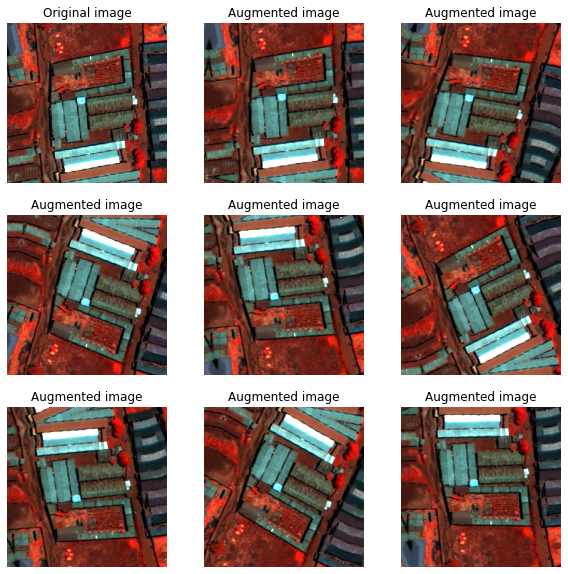

In [56]:
# Visualize the augmented data for an original image (in top left corner)
img_idx = 154
plt.rcParams["figure.facecolor"] = 'w'
pic = datagen.flow(np.expand_dims(x_train[img_idx], axis=0), batch_size =1, seed=3) 
plt.figure(figsize=(10, 10))
for i in range(9):
    if i==0:
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[img_idx]))
        plt.axis("off")
        plt.title("Original image")
    else:
        ax = plt.subplot(3, 3, i + 1)
        batch = pic.next()
        plt.imshow(Norma_Xpercentile(batch[0]))
        plt.axis("off")
        plt.title("Augmented image")
plt.savefig(os.path.join(model_path,'Data_augmentation.png'), dpi=300, bbox_inches='tight')

### 2.3 Setting up the model

In [57]:
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(output_path
                                   ,'model','DenseNet_mae_best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

In [58]:
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, mode='auto', cooldown=0, min_lr=0)

In [59]:
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited

### 2.4 Training the model

In [60]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Define a new instance of the model - Reinitialise model between diferent runs
    base_model, model = DenseNet121_model(inputshape=(224,224,3)) 
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional DenseNet121 layers
    base_model.trainable = False
    # Compilation of the model, loss function = MAE
    model.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=1e-3), 
                  metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination])

# train the model on the new data for a few epochs
# Define hyperparameter
bsize = 64
nb_epochs = 15

# Train the model 
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=bsize, shuffle=False, seed=3),
    steps_per_epoch=int(len(x_train)/bsize),
    validation_data = (x_test,y_test),
    epochs = nb_epochs, 
    callbacks = [checkpoint, reduce, early]
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/15
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
28/28 [==============================] - ETA: 0s - loss: 6.4727 - mean_absolute_error: 6.4728 - root_mean_squared_error: 9.2613 - coeff_determination: -55.9970
Epoch 1: val_mean_absolute_error improved from inf to 2.91591, saving model to /home/tgrippa/PARTIMAP_processing/output_exp_2/model/DenseNet_mae_best_performed_model.hdf5
28/28 [==============================] - 36s 673ms/step - loss: 6.4727 - mean_absolute_error: 6.4728 - root_mean_squared_error: 9.2613 - coeff_determination: -55.9970 - val_loss: 2.9157 - val_mean_absolute_error: 2.9159 - val_root_mean_squared_error: 3.6727 - val_coeff_determination: -6.7306 - lr: 0.0010
Epoch 2/15
2

In [ ]:
# Open a strategy scope.
with strategy.scope():
    # Make the base model layers trainable and recompile to makes changes works. Learning rate is reduced to not destroy all the pre-trained weights
    base_model.trainable = True
    model.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=1e-5),   # Very small learning rate to fine-tune the weights pretrained on ImageNet
                  metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination])

# train the model on the new data for a few epochs
# Define hyperparameter
bsize = 64
nb_epochs = 200

# Train the model 
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=bsize, shuffle=False, seed=3),
    steps_per_epoch=int(len(x_train)/bsize),
    validation_data = (x_test,y_test),
    epochs = nb_epochs, 
    callbacks = [checkpoint, reduce, early]
)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 366 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 366 all-reduces with algorithm = nccl, num_packs = 1
28/28 [==============================] - ETA: 0s - loss: 1.0093 - mean_absolute_error: 1.0093 - root_mean_squared_error: 1.2736 - coeff_determination: -0.0674
Epoch 1: val_mean_absolute_error improved from 0.96333 to 0.94724, saving model to /home/tgrippa/PARTIMAP_processing/output_exp_2/model/DenseNet_mae_best_performed_model.hdf5
28/28 [==============================] - 60s 702ms/step - loss: 1.0093 - mean_absolute_error: 1.0093 - root_mean_squared_error: 1.2736 - coeff_determination: -0.0674 - val_loss: 0.9472 - val_mean_absolute_error: 0.9472 - val_root_mean_squared_error: 1.1981 - val_coeff_determination: -0.0146 - lr: 1.0000e-05
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 0.9147 - mean_absolute_error: 0.9147 - root_mean_squared_error: 1.1738 - coeff_determination: 0.2566
E

### 2.5 Visualizing the training history  
In this part, we plot the loss curve and metric curve

In [ ]:
plot_loss(history, save_path=os.path.join(results_path,'mae_loss.png'), ylim=[min(history.history["loss"])*0.9,max(history.history["val_loss"])*1.1], show=True)

## 3. Assessing the model performance on test datasets

### 3.1 Save and configure the model with best performance 

In this step, we will configure the model by reloading the weights of best performance through training, and apply it on both the training and validation datasets. The scatter plots will be created to evaluate the model prediction by comparing training and validation datasets, to see if there are over-/under-estimation or over-fitting etc. 

In [ ]:
# Load best 
x, best_model = DenseNet121_model(inputshape=(224,224,3))
best_model.load_weights(checkpoint_filepath)

### 3.2 Applying the model on validation datasets 

In [ ]:
# run the model on the train and test datasets 
y_pred_test = best_model.predict(x_test) 
y_pred_train = best_model.predict(x_train)

In [ ]:
# calculate the R2 Score and RMSE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

R2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
mae_train = mean_absolute_error(y_train, y_pred_train)

print("the R2 of training dataset is: %0.4f" %R2_train)
print("the RMSE of training dataset is: %0.4f" %rmse_train)
print("the MAE of training dataset is: %0.4f" %mae_train)

R2_test = r2_score(y_test,y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test,squared=False) 
mae_test = mean_absolute_error(y_test, y_pred_test) 

print("the R2 of validation dataset is: %0.4f" %R2_test)
print("the RMSE of validation dataset is: %0.4f" %rmse_test)
print("the MAE of validation dataset is: %0.4f" %mae_test)

In [ ]:
# Export results
save_predictions(os.path.join(results_path,'predictions.hdf5'),y_pred_test,y_pred_train)
write_run_metrics_file(os.path.join(results_path,'results_metrics.txt'),R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test)

In [ ]:
plot_pred_train(y_train, y_pred_train, R2_train, rmse_train, mae_train, save_path=os.path.join(results_path,'mae_train.png'), show=True)

In [ ]:
plot_pred_test(y_test, y_pred_test, R2_test, rmse_test, mae_test, save_path=os.path.join(results_path,'mae_val.png'), show=True)